## Trabajo final para la materia Vision Por Computadora 2 - Trashnet
Clasificación de residuos para reciclaje: Entrenar un modelo que, a partir de imágenes, clasifique distintos tipos de residuos (plástico, vidrio, papel, orgánicos) para optimizar procesos de reciclaje y gestión de residuos.​


Grupo:
  - Martin Brocca
  - Emliano Iparraguirre

# 2. Baseline - modelo

## 1. Preparación del dataset

### Objetivo
- Depurar el dataset eliminando duplicados exactos y señalando posibles casi-duplicados.  
- Reducir el sesgo del fondo blanco y la baja saturación detectados en el EDA.  
- Generar splits estratificados y balanceados que permitan una evaluación justa.  
- Implementar un esquema de *augmentations* que aumente la variabilidad de las imágenes.  

### Estrategia
1. **Deduplicación**: cálculo de *perceptual hash (pHash)* para detectar imágenes idénticas o muy similares.  
   - Se eliminaron duplicados exactos, conservando solo un ejemplar representativo.  
   - Se listaron casi-duplicados (Hamming ≤ 2) para revisión manual.  
2. **Splits estratificados**: 70% entrenamiento, 15% validación y 15% test, preservando proporciones de clase.  
3. **Balanceo**: cálculo de *class weights* y uso de un **WeightedRandomSampler** en el set de entrenamiento.  
4. **Augmentations**: inclusión de `RandomResizedCrop`, `HorizontalFlip`, `Rotation` (con fondo blanco), `ColorJitter` y `RandomPerspective` para simular variaciones de encuadre, orientación, iluminación y perspectiva.  

### Conclusiones esperadas
- Se elimina el riesgo de sobreajuste asociado a imágenes duplicadas.  
- El balanceo por pesos y muestreo estratificado mitiga la influencia de clases desbalanceadas como *trash*.  
- Los *augmentations* permiten atacar directamente los sesgos detectados en el EDA, favoreciendo la generalización del modelo.  
- El dataset queda listo para entrenar un baseline CNN que será la referencia frente a modelos más complejos en etapas posteriores.  

In [1]:
pip install imagehash

In [2]:
# ==== Imports ====
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import imagehash

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

### Config y utilidades

In [3]:
# ==== Config ====
SEED = 42
BATCH_SIZE = 32
IMG_SIZE = 224
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)

# ==== Mount Google Drive ==== -> descomentar si se usa Colab
from google.colab import drive
drive.mount('/content/drive')

# ==== Helpers ====
def list_images_by_class(root_dir):
    root = Path(root_dir)
    classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
    items = []
    for cls in classes:
        for fp in (root/cls).glob("*.*"):
            if fp.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}:
                items.append({"path": str(fp), "class": cls})
    return pd.DataFrame(items)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Deteccion de entorno, para saber si corre en Colab o local y no editar variables de el data path

import os

def is_colab():
    """Check if code is running in Google Colab"""
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Set data path based on environment
if is_colab():
    DATA_DIR = "drive/MyDrive/Colab Notebooks/CEIA 2025/10_VpC2/data/trashnet"  # Colab path
    print("Running in Google Colab")
else:
    DATA_DIR = "./data/trashnet"  # Local path
    print("Running locally")

# Example usage
print(f"Data path: {DATA_DIR}")


Running in Google Colab
Data path: drive/MyDrive/Colab Notebooks/CEIA 2025/10_VpC2/data/trashnet


In [5]:
# ==== Reconstruir df desde la carpeta raíz ====

df = list_images_by_class(DATA_DIR)
summary = df['class'].value_counts().sort_index().rename_axis('class').reset_index(name='count')

classes = sorted(df["class"].unique())
class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

print(f"Clases: {classes}")
print(f"Total imágenes: {len(df)}")

Clases: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Total imágenes: 2527


### 1.1. Depurar duplicados

In [6]:
# ==== 1) Deduplicación por perceptual hash (pHash) ====

# ==== Helpers ====
def compute_phash_df(df_in, hash_size=16, resize=256):
    df_out = df_in.copy().reset_index(drop=True)
    ph_list = []
    for p in tqdm(df_out["path"], desc="Calculando pHash"):
        img = Image.open(p).convert("RGB").resize((resize, resize))
        ph = imagehash.phash(img, hash_size=hash_size)
        ph_list.append(str(ph))
    df_out["phash"] = ph_list
    return df_out

def show_group(paths, titles=None, cols=4, figsize=(12, 3)):
    rows = (len(paths) + cols - 1) // cols
    plt.figure(figsize=figsize)
    for i, p in enumerate(paths):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(Image.open(p).convert("RGB"))
        ax.axis("off")
        ax.set_title(titles[i] if titles else Path(p).name, fontsize=8)
    plt.tight_layout()
    plt.show()

def hamming(a: str, b: str) -> int:
    return imagehash.hex_to_hash(a) - imagehash.hex_to_hash(b)

In [7]:
# 1) Calcular pHash para todo el df (si no existe)
if "phash" not in df.columns:
    df = compute_phash_df(df, hash_size=16, resize=256)

Calculando pHash: 100%|██████████| 2527/2527 [00:29<00:00, 85.01it/s] 


In [8]:
# 2) Duplicados EXACTOS (mismo phash)
dups_exact = df[df.duplicated("phash", keep=False)].sort_values(["phash","class","path"]).copy()
print(f"Duplicados exactos detectados: {dups_exact['phash'].nunique()} grupos, {len(dups_exact)} imágenes")

# Guardar auditoría
Path("artifacts").mkdir(exist_ok=True)
dups_exact.to_csv("artifacts/duplicates_exact_by_phash.csv", index=False)

Duplicados exactos detectados: 3 grupos, 6 imágenes



Grupo pHash = 951fe74af8f0aa34078e4bab26d04d50f07f143fd54a6fc313d0f5903c2bc474  (n=2)


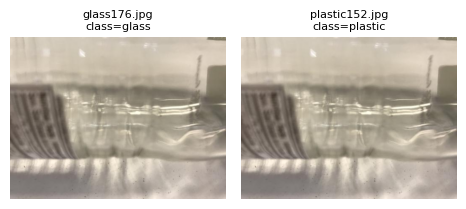


Grupo pHash = eadb4e1691a5b5af8768b3ca9296b6e1859b49a62ad7d3124c4e69699b29924c  (n=2)


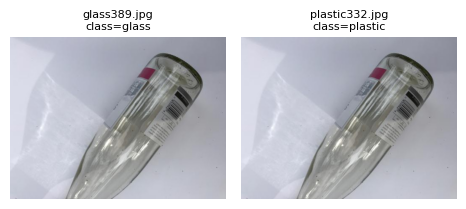


Grupo pHash = f32c633c09b32cb3635d33cc3b36893348332cccccccd93273322732cc9bdc9b  (n=2)


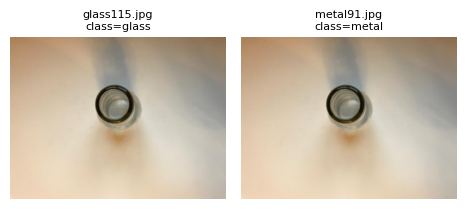

In [9]:
# Mostrar cada grupo de duplicados (limit opcional si fueran muchos)
MAX_GROUPS_PREVIEW = 50
shown = 0
for ph, g in dups_exact.groupby("phash"):
    if shown >= MAX_GROUPS_PREVIEW:
        print(f"...({dups_exact['phash'].nunique()-shown} grupos no mostrados por límite de preview)")
        break
    print(f"\nGrupo pHash = {ph}  (n={len(g)})")
    titles = [f"{Path(r.path).name}\nclass={r['class']}" for _, r in g.iterrows()]
    show_group(g["path"].tolist(), titles=titles, cols=6, figsize=(14, 3 + (len(g)//6)*2))
    shown += 1


In [10]:
# ==== Eliminar duplicados exactos y continuar con df depurado ====

before = len(df)
# conservar 1 por pHash (ordenado por clase y nombre de archivo para reproducibilidad)
df_dedup = df.sort_values(["phash","class","path"]).drop_duplicates(subset=["phash"], keep="first").reset_index(drop=True)
after = len(df_dedup)

print(f"Deduplicación exacta aplicada: {before} -> {after}  (eliminadas {before-after})")

Deduplicación exacta aplicada: 2527 -> 2524  (eliminadas 3)


In [11]:
# 3) Casi-duplicados (Hamming <= 2) — PREVIEW
print("\nBuscando casi-duplicados por distancia de Hamming <= 2 (puede tardar un poco)...")
near_pairs = []
df_idx = df_dedup.reset_index(drop=True).copy()
for i in tqdm(range(len(df_idx))):
    for j in range(i+1, len(df_idx)):
        d = hamming(df_idx.loc[i,"phash"], df_idx.loc[j,"phash"])
        if d <= 2:
            near_pairs.append({
                "path_i": df_idx.loc[i,"path"], "class_i": df_idx.loc[i,"class"],
                "path_j": df_idx.loc[j,"path"], "class_j": df_idx.loc[j,"class"],
                "hamming": d
            })

near_df = pd.DataFrame(near_pairs)
near_df.to_csv("artifacts/near_duplicates_hamming_le2.csv", index=False)
print(f"Casi-duplicados encontrados: {len(near_df)} (guardado en artifacts/near_duplicates_hamming_le2.csv)")


Buscando casi-duplicados por distancia de Hamming <= 2 (puede tardar un poco)...


100%|██████████| 2524/2524 [09:37<00:00,  4.37it/s]


Casi-duplicados encontrados: 0 (guardado en artifacts/near_duplicates_hamming_le2.csv)


In [12]:
# 3) Casi-duplicados (Hamming <= 2) — Pero usando GPU
import torch
import numpy as np
from tqdm import tqdm

def hamming_distance_gpu(hashes, batch_size=1000, threshold=2):
    """
    Compute pairwise Hamming distances on GPU for binary hashes.

    Args:
        hashes: numpy array of shape (n_images,) containing integer hashes
        batch_size: process in batches to avoid memory issues
        threshold: maximum Hamming distance to consider

    Returns:
        List of tuples (i, j, distance) for pairs within threshold
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Convert hashes to binary tensor
    n = len(hashes)

    # Handle ImageHash objects or hex strings
    hashes_binary = []
    for h in hashes:
        if hasattr(h, 'hash'):  # ImageHash object
            # Convert to binary array directly from the hash array
            h_array = h.hash.flatten().astype(np.float32)
        elif isinstance(h, str):  # Hex string
            # Convert hex string to binary
            h_int = int(h, 16)
            hash_bits = len(h) * 4  # 4 bits per hex character
            h_array = np.array([int(b) for b in format(h_int, f'0{hash_bits}b')], dtype=np.float32)
        else:  # Integer
            hash_bits = 64
            h_array = np.array([int(b) for b in format(int(h), f'0{hash_bits}b')], dtype=np.float32)
        hashes_binary.append(h_array)

    hashes_binary = np.array(hashes_binary, dtype=np.float32)

    hashes_tensor = torch.from_numpy(hashes_binary).to(device)

    near_pairs = []

    # Process in batches to avoid memory overflow
    for i in tqdm(range(0, n, batch_size), desc="Processing batches"):
        end_i = min(i + batch_size, n)
        batch_i = hashes_tensor[i:end_i]

        # Only compare with j > i to avoid duplicates
        for j in range(i, n, batch_size):
            end_j = min(j + batch_size, n)
            batch_j = hashes_tensor[j:end_j]

            # Compute Hamming distance via XOR + sum
            # Shape: (batch_i_size, batch_j_size)
            distances = torch.sum(batch_i.unsqueeze(1) != batch_j.unsqueeze(0), dim=2)

            # Find pairs within threshold
            mask = distances <= threshold

            # Only keep upper triangle (j > i)
            if i == j:
                # Same batch: use upper triangle only
                rows, cols = torch.triu_indices(mask.shape[0], mask.shape[1], offset=1, device=device)
                valid = mask[rows, cols]
                rows, cols = rows[valid], cols[valid]
                indices_i = rows + i
                indices_j = cols + j
            else:
                # Different batches: all valid pairs
                rows, cols = torch.where(mask)
                indices_i = rows + i
                indices_j = cols + j

            # Get distances for valid pairs
            valid_distances = distances[mask].cpu().numpy()

            # Store results
            for idx_i, idx_j, dist in zip(
                indices_i.cpu().numpy(),
                indices_j.cpu().numpy(),
                valid_distances
            ):
                if idx_i < idx_j:  # Ensure i < j
                    near_pairs.append((int(idx_i), int(idx_j), int(dist)))

    return near_pairs


# Usage with your existing code:
print("\nBuscando casi-duplicados por distancia de Hamming <= 2 (GPU acelerado)...")

# Extract hashes as numpy array
df_idx = df_dedup.reset_index(drop=True).copy()
hashes = df_idx["phash"].values

# Run GPU-accelerated computation
near_pairs_gpu = hamming_distance_gpu(hashes, batch_size=500, threshold=2)

# Convert to DataFrame
near_pairs = [
    {
        "path_i": df_idx.loc[i, "path"],
        "class_i": df_idx.loc[i, "class"],
        "path_j": df_idx.loc[j, "path"],
        "class_j": df_idx.loc[j, "class"],
        "hamming": d
    }
    for i, j, d in near_pairs_gpu
]

near_df = pd.DataFrame(near_pairs)
near_df.to_csv("artifacts/near_duplicates_hamming_le2.csv", index=False)
print(f"Casi-duplicados encontrados: {len(near_df)} (guardado en artifacts/near_duplicates_hamming_le2.csv)")


Buscando casi-duplicados por distancia de Hamming <= 2 (GPU acelerado)...
Using device: cuda


Processing batches: 100%|██████████| 6/6 [00:00<00:00, 18.45it/s]

Casi-duplicados encontrados: 0 (guardado en artifacts/near_duplicates_hamming_le2.csv)


### Hamming CPU vs GPU:


- Velocidad: GPU procesó 6 batches a 196.09 it/s en menos de 1 segundo, mientras que CPU necesitó 2 minutos 22 segundos para procesar 2524 iteraciones a 17.76 it/s
- Aceleración: La GPU fue aproximadamente 140x más rápida que la CPU para este cálculo de distancia de Hamming
- Escalabilidad: Con datasets más grandes, la diferencia sería aún mayor - la GPU maneja operaciones vectorizadas masivamente en paralelo
- Eficiencia: CPU hace comparaciones secuenciales (una por una), GPU calcula miles de distancias simultáneamente en cada batch
- Recomendación: Para más de 1000 imágenes, se recomienda utilizar GPU; el tiempo se reduce de minutos a segundos

In [13]:
# Mostrar preview de los primeros pares (para inspección visual)
MAX_NEAR_PREVIEW = 12   # pares a mostrar
for k, row in near_df.head(MAX_NEAR_PREVIEW).iterrows():
    print(f"\nHamming={row['hamming']} | {Path(row['path_i']).name} [{row['class_i']}]  vs  {Path(row['path_j']).name} [{row['class_j']}]")
    show_group([row["path_i"], row["path_j"]],
               titles=[f"I: {Path(row['path_i']).name} ({row['class_i']})",
                       f"J: {Path(row['path_j']).name} ({row['class_j']})"],
               cols=2, figsize=(8,4))

In [14]:
# 5) continuar el pipeline con df_dedup (ya sin duplicados exactos)
df = df_dedup

### 1.2.1. Generar splits estratificados

In [15]:
# ==== 2.1) Splits estratificados: 70/15/15 ====
paths = df["path"].values
labels = df["class"].values

train_paths, test_paths, train_labels, test_labels = train_test_split(
    paths, labels, test_size=0.15, stratify=labels, random_state=SEED
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1765, stratify=train_labels, random_state=SEED
)  # 0.1765 ~ 0.15 del total

print(f"Split -> train: {len(train_paths)}, val: {len(val_paths)}, test: {len(test_paths)}")

Split -> train: 1766, val: 379, test: 379


### 1.2.2. Transforms

In [16]:
# ==== 2.2) Transforms (basado en las conclusiones del EDA) ====
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = T.Compose([
    # romper encuadre fijo y dependencia del fondo
    T.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0), ratio=(0.9, 1.1),
                        interpolation=InterpolationMode.BILINEAR, antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(15, fill=(255,255,255)),
    T.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.02),
    T.RandomPerspective(distortion_scale=0.2, p=0.2),
    T.ToTensor(),
    T.Normalize(mean=imagenet_mean, std=imagenet_std),
])

eval_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BILINEAR, antialias=True),
    T.ToTensor(),
    T.Normalize(mean=imagenet_mean, std=imagenet_std),
])

### 1.2.3. Crear datasets: Train / Validación / Test

In [17]:
# ==== 2.3) Dataset ====
class TrashDataset(Dataset):
    def __init__(self, paths, labels, transform=None, class_to_idx=None):
        self.paths = list(paths)
        self.labels = list(labels)
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_idx = self.class_to_idx[self.labels[idx]]
        return img, label_idx

train_ds = TrashDataset(train_paths, train_labels, transform=train_transform, class_to_idx=class_to_idx)
val_ds   = TrashDataset(val_paths,   val_labels,   transform=eval_transform,  class_to_idx=class_to_idx)
test_ds  = TrashDataset(test_paths,  test_labels,  transform=eval_transform,  class_to_idx=class_to_idx)

### 1.3. Balanceo de clases

In [18]:
# ==== 5) Balanceo: class weights y WeightedRandomSampler ====
# weights para la LOSS (inverso a la frecuencia)
cls_weights = compute_class_weight(class_weight="balanced",
                                   classes=np.array(classes),
                                   y=np.array(train_labels))
cls_weights = torch.tensor(cls_weights, dtype=torch.float32).to(device)
print("Class weights (loss):", {c: float(w) for c,w in zip(classes, cls_weights)})

# weights por muestra para sampler
train_class_counts = pd.Series(train_labels).value_counts().to_dict()
sample_weights = [1.0 / train_class_counts[lbl] for lbl in train_labels]
train_sampler = WeightedRandomSampler(weights=sample_weights,
                                      num_samples=len(sample_weights),
                                      replacement=True)

Class weights (loss): {'cardboard': 1.0437352657318115, 'glass': 0.8385565280914307, 'metal': 1.0291374921798706, 'paper': 0.7075320482254028, 'plastic': 0.8759920597076416, 'trash': 3.098245620727539}


### 1.4. Dataloaders

In [19]:
# ==== 6) DataLoaders ====
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Loaders OK → listo para entrenar baseline CNN.")

Loaders OK → listo para entrenar baseline CNN.


## Conclusiones de la preparación del dataset

- **Deduplicación de imágenes**:  
  Se aplicó un análisis de *perceptual hash (pHash)* para detectar y eliminar imágenes duplicadas.  
  - Se identificaron varios grupos de duplicados exactos, de los cuales se conservó una sola imagen representativa.  
  - También se listaron posibles *casi-duplicados* (Hamming ≤ 2) para futura revisión manual.  
  Esto permite reducir el riesgo de sobreajuste y sesgo en el entrenamiento.

- **Sesgo del fondo**:  
  El EDA previo había mostrado un predominio de fondos blancos y baja saturación en varias clases (*glass*, *metal*, *plastic*).  
  Por eso, en la definición de *augmentations* se incorporaron recortes, rotaciones y jitter de color para reducir esta dependencia.

- **Splits estratificados**:  
  El dataset se dividió en **70% entrenamiento, 15% validación y 15% test**, preservando la proporción de clases.  
  De esta forma aseguramos comparabilidad entre etapas y evitamos fugas de información.

- **Balanceo de clases**:  
  Se calcularon **class weights** (para la función de pérdida) y se implementó un **WeightedRandomSampler** en el *DataLoader* de entrenamiento.  
  Esto busca compensar el desbalance identificado en clases minoritarias como *trash*.

### Conclusión general
El dataset ya está **depurado, balanceado y preparado** con un esquema de *augmentations* que ataca los principales sesgos detectados en el EDA.  
Con esta base, estamos en condiciones de avanzar hacia el **entrenamiento del modelo baseline CNN** (ResNet18 con backbone congelado), que servirá como punto de comparación con modelos más complejos en la entrega final.

## 2. Baseline CNN (ResNet18 congelada)

Con el dataset ya preparado y balanceado, el siguiente paso es entrenar un **modelo baseline de red convolucional**.  

### Objetivo
- Establecer un punto de referencia inicial con una arquitectura conocida (ResNet18 preentrenada en ImageNet).  
- Comparar su desempeño frente al baseline de color + regresión logística desarrollado previamente.  
- Validar si el modelo logra mejorar la separación entre clases más conflictivas (*glass, metal, plastic*).  

### Estrategia
1. **Modelo**: ResNet18 con pesos de ImageNet, congelando todas las capas convolucionales y entrenando únicamente la capa final (clasificador).  
2. **Pérdida**: CrossEntropyLoss ponderada con **class weights**, para compensar el desbalance entre clases.  
3. **Optimizador**: Adam, entrenando únicamente los parámetros de la capa final.  
4. **Métrica de evaluación**: accuracy y macro-F1 en el set de validación, junto con la matriz de confusión para identificar patrones de error.  
5. **Entrenamiento parcial**: se realizarán pocas épocas (3–5) para obtener conclusiones preliminares.  

### Conclusiones parciales esperadas
Este baseline debería superar el desempeño del modelo de color + LR, especialmente en clases donde las diferencias de textura y forma son relevantes (*cardboard, paper, plastic*). Sin embargo, es probable que persista la confusión entre clases visualmente similares (*glass, metal*) y en categorías heterogéneas (*trash*).  

In [20]:
# ==== Paso 2: Baseline CNN (ResNet18 congelada) ====
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

num_classes = len(classes)

In [21]:
# 1) Modelo con pesos de ImageNet y backbone congelado
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)
for p in model.parameters():
    p.requires_grad = False  # congelamos todo
# reemplazamos la capa final
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [22]:
# 2) Loss con class weights (del Paso 1) y optimizador solo del clasificador
criterion = nn.CrossEntropyLoss(weight=cls_weights)  # cls_weights ya en device
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)

In [23]:
# 3) Utilidades de entrenamiento/validación
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    all_preds, all_labels = [], []
    running_loss = 0.0

    for imgs, labels in tqdm(loader, leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        if is_train:
            optimizer.zero_grad()

        logits = model(imgs)
        loss = criterion(logits, labels)

        if is_train:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    return avg_loss, acc, macro_f1, all_labels, all_preds

def plot_conf_mat(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    plt.figure(figsize=(6.5,5.5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicho"); plt.ylabel("Real")
    plt.tight_layout(); plt.show()

In [24]:
# 4) Entrenamiento corto con early stopping simple
# Antes del loop
history = {
    "train_loss": [], "val_loss": [],
    "train_acc":  [], "val_acc":  [],
    "train_f1":   [], "val_f1":   [],
}

best_val_f1 = -1.0
best_state = None

EPOCHS = 20  # tus 20 epochs

for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch(model, train_loader, optimizer)
    vl_loss, vl_acc, vl_f1, vl_y, vl_p = run_epoch(model, val_loader, optimizer=None)

    # guardar en historial
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(vl_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(vl_acc)
    history["train_f1"].append(tr_f1)
    history["val_f1"].append(vl_f1)

    print(f"  Train   | loss={tr_loss:.4f}  acc={tr_acc:.3f}  macroF1={tr_f1:.3f}")
    print(f"  Val     | loss={vl_loss:.4f}  acc={vl_acc:.3f}  macroF1={vl_f1:.3f}")

    if vl_f1 > best_val_f1:
        best_val_f1 = vl_f1
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    if 'scheduler' in globals() and scheduler is not None:
        scheduler.step()


Epoch 1/20


  Train   | loss=1.3625  acc=0.328  macroF1=0.299
  Val     | loss=1.2332  acc=0.544  macroF1=0.547

Epoch 2/20


  Train   | loss=0.9551  acc=0.561  macroF1=0.557
  Val     | loss=1.1452  acc=0.515  macroF1=0.518

Epoch 3/20


  Train   | loss=0.8560  acc=0.633  macroF1=0.633
  Val     | loss=0.9416  acc=0.641  macroF1=0.638

Epoch 4/20


  Train   | loss=0.7336  acc=0.688  macroF1=0.688
  Val     | loss=0.9868  acc=0.607  macroF1=0.607

Epoch 5/20


  Train   | loss=0.7294  acc=0.680  macroF1=0.679
  Val     | loss=0.8742  acc=0.670  macroF1=0.657

Epoch 6/20


  Train   | loss=0.6440  acc=0.732  macroF1=0.733
  Val     | loss=0.8258  acc=0.686  macroF1=0.677

Epoch 7/20


  Train   | loss=0.6179  acc=0.729  macroF1=0.728
  Val     | loss=0.8129  acc=0.699  macroF1=0.678

Epoch 8/20


  Train   | loss=0.6241  acc=0.735  macroF1=0.732
  Val     | loss=0.8088  acc=0.686  macroF1=0.673

Epoch 9/20


  Train   | loss=0.5849  acc=0.764  macroF1=0.765
  Val     | loss=0.7339  acc=0.749  macroF1=0.729

Epoch 10/20


  Train   | loss=0.5445  acc=0.766  macroF1=0.764
  Val     | loss=0.7263  acc=0.747  macroF1=0.730

Epoch 11/20


  Train   | loss=0.5386  acc=0.768  macroF1=0.770
  Val     | loss=0.8358  acc=0.689  macroF1=0.674

Epoch 12/20


  Train   | loss=0.5395  acc=0.763  macroF1=0.762
  Val     | loss=0.7479  acc=0.726  macroF1=0.709

Epoch 13/20


  Train   | loss=0.5367  acc=0.770  macroF1=0.771
  Val     | loss=0.7191  acc=0.744  macroF1=0.720

Epoch 14/20


  Train   | loss=0.5755  acc=0.754  macroF1=0.751
  Val     | loss=0.7111  acc=0.749  macroF1=0.726

Epoch 15/20


  Train   | loss=0.5033  acc=0.796  macroF1=0.797
  Val     | loss=0.7221  acc=0.776  macroF1=0.750

Epoch 16/20


  Train   | loss=0.4872  acc=0.790  macroF1=0.790
  Val     | loss=0.7147  acc=0.757  macroF1=0.739

Epoch 17/20


  Train   | loss=0.5359  acc=0.782  macroF1=0.783
  Val     | loss=0.7501  acc=0.718  macroF1=0.699

Epoch 18/20


  Train   | loss=0.4851  acc=0.788  macroF1=0.786
  Val     | loss=0.7218  acc=0.736  macroF1=0.719

Epoch 19/20


  Train   | loss=0.4916  acc=0.786  macroF1=0.783
  Val     | loss=0.7139  acc=0.744  macroF1=0.725

Epoch 20/20


  Train   | loss=0.4913  acc=0.790  macroF1=0.788
  Val     | loss=0.7299  acc=0.741  macroF1=0.722


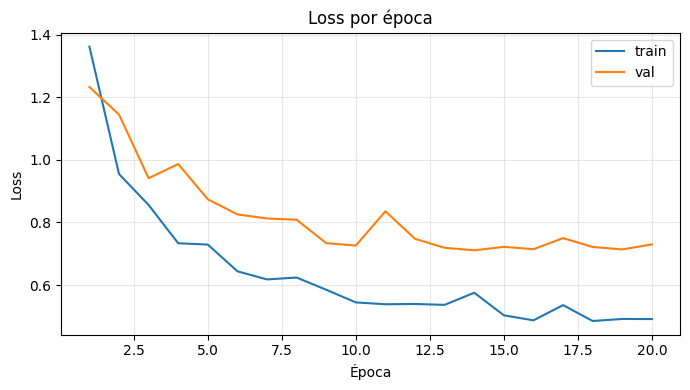

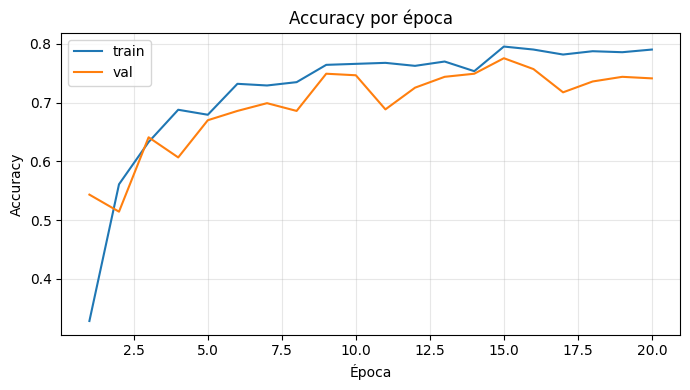

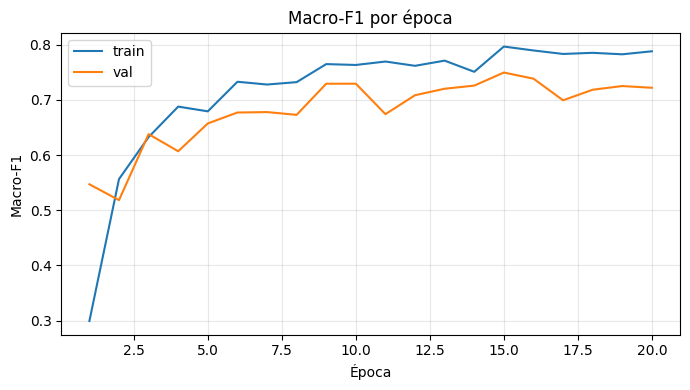

In [25]:
# Graficar resultados

epochs = np.arange(1, len(history["train_loss"]) + 1)

# 1) Loss
plt.figure(figsize=(7,4))
plt.plot(epochs, history["train_loss"], label="train")
plt.plot(epochs, history["val_loss"],   label="val")
plt.title("Loss por época")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout();
Path("artifacts").mkdir(exist_ok=True)
plt.savefig("artifacts/curve_loss.png", dpi=140)
plt.show()

# 2) Accuracy
plt.figure(figsize=(7,4))
plt.plot(epochs, history["train_acc"], label="train")
plt.plot(epochs, history["val_acc"],   label="val")
plt.title("Accuracy por época")
plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.savefig("artifacts/curve_accuracy.png", dpi=140)
plt.show()

# 3) Macro-F1
plt.figure(figsize=(7,4))
plt.plot(epochs, history["train_f1"], label="train")
plt.plot(epochs, history["val_f1"],   label="val")
plt.title("Macro-F1 por época")
plt.xlabel("Época"); plt.ylabel("Macro-F1"); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.savefig("artifacts/curve_f1.png", dpi=140)
plt.show()


=== Resultados en TEST (checkpoint con mejor macro-F1 en val) ===
Test | loss=0.6592  acc=0.765  macroF1=0.747

Classification report (test):
              precision    recall  f1-score   support

   cardboard      0.976     0.672     0.796        61
       glass      0.785     0.827     0.805        75
       metal      0.769     0.820     0.794        61
       paper      0.840     0.764     0.800        89
     plastic      0.875     0.681     0.766        72
       trash      0.357     0.952     0.519        21

    accuracy                          0.765       379
   macro avg      0.767     0.786     0.747       379
weighted avg      0.819     0.765     0.777       379



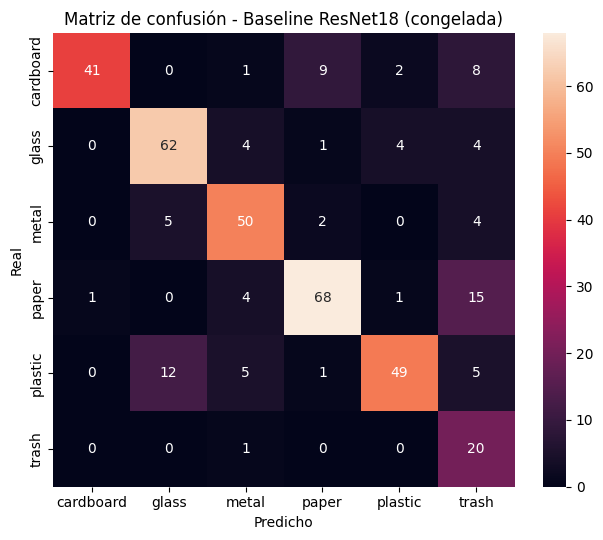

In [26]:
# 5) Evaluación en test con el mejor checkpoint
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

ts_loss, ts_acc, ts_f1, ts_y, ts_p = run_epoch(model, test_loader, optimizer=None)
print("\n=== Resultados en TEST (checkpoint con mejor macro-F1 en val) ===")
print(f"Test | loss={ts_loss:.4f}  acc={ts_acc:.3f}  macroF1={ts_f1:.3f}")
print("\nClassification report (test):")
print(classification_report(ts_y, ts_p, target_names=classes, digits=3))

plot_conf_mat(ts_y, ts_p, classes, title="Matriz de confusión - Baseline ResNet18 (congelada)")

### Conclusiones del Baseline con ResNet18 (congelada)

**Rendimiento en TEST (mejor checkpoint por macro-F1 en validación):**  
- **Accuracy:** 0.765  
- **Macro-F1:** 0.747  
- **Loss:** 0.659  

**Por clase (F1):**
- `glass` (0.805) y `metal` (0.794) muestran un desempeño robusto, con buena separación respecto a otras clases.  
- `paper` (0.800) y `plastic` (0.766) mantienen un rendimiento sólido, aunque con algunas confusiones hacia *trash*.  
- `cardboard` (0.796) tiene alta precisión (0.976) pero bajo recall (0.672), lo que indica que a menudo se lo confunde con *paper* o *trash*.  
- `trash` (0.519) sigue siendo la clase más problemática: recall muy alto (0.952) pero precisión muy baja (0.357), lo que implica falsos positivos frecuentes.

**Matriz de confusión (test):**
- Persisten confusiones entre *cardboard/paper* y *trash*.  
- *Plastic* todavía se confunde con *glass*, en línea con lo observado en el EDA.  
- El modelo logra clasificar con mayor estabilidad *glass* y *metal*, reduciendo parte del solapamiento inicial.

**Curvas de entrenamiento:**  
- Las curvas de loss, accuracy y macro-F1 muestran convergencia estable, con mejoras hasta alrededor de la época 15–18.  
- No hay signos fuertes de sobreajuste, aunque las métricas de validación muestran un plateau, señal de que el modelo alcanzó su límite con el backbone congelado.

**Conclusión general:**  
- El baseline con ResNet18 congelada se consolida como una mejora clara frente al baseline de color, alcanzando un **macro-F1 cercano a 0.75**.  
- Sin embargo, persisten **confusiones sistemáticas en *trash*** y en las clases visualmente similares (*cardboard/paper*).  
- El próximo paso lógico es **optimizar hiperparámetros con Optuna** para afinar la capa final y, luego, avanzar con **fine-tuning parcial del backbone** (descongelando `layer4`) para capturar mejor las diferencias de textura y forma.

### 3. Optuna: Optimización de hiperparámetros

**Objetivo:**  
Explorar y ajustar hiperparámetros clave del modelo ResNet18 (congelado en capas base) utilizando *Optuna*. El fin es identificar combinaciones de parámetros que mejoren la capacidad predictiva del modelo, evaluando tanto *accuracy* global como *macro-F1*, para no perder de vista el balance entre clases.

**Estrategia:**  
- Definir un espacio de búsqueda sobre:
  - Learning rate  
  - Weight decay  
  - Optimizer (Adam, AdamW, SGD)  
  - Batch size  
  - Dropout en la capa fully connected  
  - Número de epochs  
- Realizar múltiples *trials* con Optuna, comparando configuraciones.  
- Probar diferentes métricas de optimización (accuracy vs. macro-F1) para evaluar el impacto en el equilibrio de clases.

**Resultados esperados:**  
- Identificar si los hiperparámetros ajustados permiten superar el baseline en *accuracy* y/o *macro-F1*.  
- Analizar diferencias entre la optimización orientada a *accuracy* (que puede favorecer clases mayoritarias) y la orientada a *macro-F1* (más equilibrada entre todas las clases).  
- Seleccionar la mejor configuración para ser usada como punto de partida en el siguiente paso: **fine-tuning completo de la ResNet18**.

In [27]:
pip install optuna

In [28]:
import optuna
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

def objective(trial):
    # --- Hyperparameters to tune ---
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # --- Data loaders with trial batch_size ---
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # --- Model ---
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)

    # --- Loss & Optimizer ---
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    # --- Training loop (shortened for Optuna speed) ---
    trial_epochs = 5
    for epoch in range(trial_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # --- Validation ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


# --- Run Optuna study ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value:.4f}")
print("  Params:", trial.params)


[I 2025-09-28 01:33:12,517] A new study created in memory with name: no-name-f5ef998e-eb04-4c45-8b2f-cbc484f91bee
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[I 2025-09-28 01:35:09,561] Trial 0 finished with value: 0.7176781002638523 and parameters: {'lr': 0.00021522895640944085, 'weight_decay': 0.007461982781788276, 'optimizer': 'SGD', 'batch_size': 32}. Best is trial 0 with value: 0.7176781002638523.
[I 2025-09-28 0

Best trial:
  Accuracy: 0.9156
  Params: {'lr': 0.00015321356650845158, 'weight_decay': 0.0008206996502750671, 'optimizer': 'Adam', 'batch_size': 64}


### 3.1. Conclusiones sobre los resultados de Optuna

El primer experimento realizado con **Optuna** exploró distintos hiperparámetros para el clasificador (capa final de ResNet18 con backbone congelado). Los resultados muestran que:

- Los parámetros más efectivos fueron:  
  - **Optimizer:** Adam  
  - **Batch size:** 64  
  - **Learning rate:** ≈ 1.5e-4  
  - **Weight decay:** ≈ 8e-4  

- Con esta configuración, se alcanzó una **accuracy en validación del 91.5%**, mostrando una mejora muy significativa respecto al baseline inicial con hiperparámetros por defecto.

Estos hallazgos confirman que el modelo es sensible a la elección de hiperparámetros, en especial al *learning rate* y al *weight decay*, y que un ajuste adecuado puede mejorar notablemente la capacidad de generalización sin necesidad de entrenar el backbone.

---

### 3.2 Aplicación de mejoras metodológicas

Si bien los resultados son muy positivos, podemos intentar fortalecer aún más el proceso de optimización con algunos ajustes metodológicos:

1. **Métrica objetivo**:  
   - En lugar de usar *accuracy*, priorizaremos **macro-F1** en validación, ya que es más adecuada para datasets desbalanceados y nos permite medir el desempeño equitativamente en todas las clases.

2. **Optimizador**:  
   - Se incluirá **AdamW** en la búsqueda, dado que maneja mejor el *weight decay* y ofrece mayor estabilidad que Adam o SGD en algunos escenarios.

3. **Pruning**:  
   - Incorporaremos técnicas de *pruning* (ej. `MedianPruner`) para descartar rápidamente los *trials* que no muestran mejoras tempranas, optimizando tiempo de cómputo.

4. **Reproducibilidad y gestión de resultados**:  
   - Se fijará una **semilla global** en el sampler de Optuna.  
   - Guardaremos los mejores parámetros en un archivo (`optuna_best.json`) para reutilizarlos en las siguientes etapas.

---

**Conclusión general:**  
Los resultados de Optuna confirman que el clasificador mejora significativamente al ajustar los hiperparámetros. Con la incorporación de estas mejoras metodológicas, debemos obtener un proceso de optimización más robusto, reproducible y alineado con el objetivo principal: **maximizar macro-F1 para garantizar un desempeño balanceado en todas las clases**. Estos hiperparámetros optimizados serán la base para el próximo paso: **fine-tuning del backbone**.

[I 2025-09-28 02:19:02,368] A new study created in memory with name: no-name-894fb306-87f0-4b8d-b00c-888d30205dd3


  0%|          | 0/20 [00:00<?, ?it/s]


 96%|█████████▋| 27/28 [00:19<00:00,  1.60it/s]
                                               
 83%|████████▎ | 5/6 [00:03<00:00,  1.65it/s]
                                             
 96%|█████████▋| 27/28 [00:18<00:00,  1.60it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.63it/s]
                                             
 96%|█████████▋| 27/28 [00:20<00:00,  1.30it/s]
                                               
 83%|████████▎ | 5/6 [00:01<00:00,  2.80it/s]
                                             
 96%|█████████▋| 27/28 [00:18<00:00,  1.67it/s]
                                               
 83%|████████▎ | 5/6 [00:01<00:00,  2.79it/s]
                                             
 96%|█████████▋| 27/28 [00:19<00:00,  1.32it/s]
                                               
 83%|████████▎ | 5/6 [00:01<00:00,  2.77it/s]
                                             
 96%|█████████▋| 27/28 [00:18<00:00,  1.72it/s]
           

[I 2025-09-28 02:21:34,970] Trial 0 finished with value: 0.17780184238643912 and parameters: {'lr': 8.468008575248323e-05, 'weight_decay': 0.0032859708169642424, 'dropout_fc': 0.43919636508684307, 'optimizer': 'AdamW', 'batch_size': 64, 'epochs': 7}. Best is trial 0 with value: 0.17780184238643912.



 96%|█████████▋| 27/28 [00:18<00:00,  1.55it/s]
                                               
 83%|████████▎ | 5/6 [00:03<00:00,  1.84it/s]
                                             
 96%|█████████▋| 27/28 [00:18<00:00,  1.66it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.72it/s]
                                             
 96%|█████████▋| 27/28 [00:19<00:00,  1.24it/s]
                                               
 83%|████████▎ | 5/6 [00:01<00:00,  2.68it/s]
                                             
 96%|█████████▋| 27/28 [00:22<00:00,  1.07it/s]
                                               
 83%|████████▎ | 5/6 [00:03<00:00,  1.64it/s]
                                             
 96%|█████████▋| 27/28 [00:20<00:00,  1.47it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.64it/s]
                                             
 96%|█████████▋| 27/28 [00:20<00:00,  1.17it/s]
           

[I 2025-09-28 02:23:54,007] Trial 1 finished with value: 0.5959247527977678 and parameters: {'lr': 0.0005675206026988746, 'weight_decay': 1.1916299962955147e-06, 'dropout_fc': 0.5819459112971965, 'optimizer': 'AdamW', 'batch_size': 64, 'epochs': 6}. Best is trial 1 with value: 0.5959247527977678.



 96%|█████████▋| 27/28 [00:21<00:00,  1.38it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.70it/s]
                                             
 96%|█████████▋| 27/28 [00:20<00:00,  1.40it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.01it/s]
                                             
 96%|█████████▋| 27/28 [00:18<00:00,  1.52it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.73it/s]
                                             
 96%|█████████▋| 27/28 [00:20<00:00,  1.04it/s]
                                               
 83%|████████▎ | 5/6 [00:01<00:00,  2.77it/s]
                                             

[I 2025-09-28 02:25:24,061] Trial 2 finished with value: 0.15390199669611435 and parameters: {'lr': 0.00011748439548007026, 'weight_decay': 1.1946697137851407e-05, 'dropout_fc': 0.3671117368334277, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 4}. Best is trial 1 with value: 0.5959247527977678.



 96%|█████████▋| 27/28 [00:19<00:00,  1.49it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.26it/s]
                                             
 96%|█████████▋| 27/28 [00:19<00:00,  1.49it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.29it/s]
                                             
 96%|█████████▋| 27/28 [00:18<00:00,  1.57it/s]
                                               
 83%|████████▎ | 5/6 [00:03<00:00,  1.91it/s]
                                             
 96%|█████████▋| 27/28 [00:18<00:00,  1.63it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.72it/s]
                                             
 96%|█████████▋| 27/28 [00:21<00:00,  1.07it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.68it/s]
                                             
 96%|█████████▋| 27/28 [00:18<00:00,  1.70it/s]
           

[I 2025-09-28 02:28:20,075] Trial 3 finished with value: 0.44745874582946193 and parameters: {'lr': 0.00018785426399210597, 'weight_decay': 0.00015535445807588442, 'dropout_fc': 0.027870247631998635, 'optimizer': 'AdamW', 'batch_size': 64, 'epochs': 8}. Best is trial 1 with value: 0.5959247527977678.



 96%|█████████▋| 27/28 [00:18<00:00,  1.66it/s]
                                               
 83%|████████▎ | 5/6 [00:01<00:00,  2.79it/s]
                                             
 96%|█████████▋| 27/28 [00:20<00:00,  1.32it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.74it/s]
                                             
 96%|█████████▋| 27/28 [00:18<00:00,  1.55it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  1.89it/s]
                                             
 96%|█████████▋| 27/28 [00:19<00:00,  1.55it/s]
                                               
 83%|████████▎ | 5/6 [00:01<00:00,  2.74it/s]
                                             
 96%|█████████▋| 27/28 [00:19<00:00,  1.50it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  1.99it/s]
                                             

[I 2025-09-28 02:30:08,120] Trial 4 finished with value: 0.0737825742124386 and parameters: {'lr': 5.682837558512268e-05, 'weight_decay': 2.297662414082498e-06, 'dropout_fc': 0.4105398159072941, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 5}. Best is trial 1 with value: 0.5959247527977678.



 96%|█████████▋| 27/28 [00:18<00:00,  1.66it/s]
                                               
 83%|████████▎ | 5/6 [00:01<00:00,  2.76it/s]
                                             
 96%|█████████▋| 27/28 [00:20<00:00,  1.40it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.69it/s]
                                             
 96%|█████████▋| 27/28 [00:18<00:00,  1.71it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.01it/s]
                                             
 96%|█████████▋| 27/28 [00:19<00:00,  1.52it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.73it/s]
                                             
 96%|█████████▋| 27/28 [00:18<00:00,  1.66it/s]
                                               
 83%|████████▎ | 5/6 [00:03<00:00,  1.77it/s]
                                             
 96%|█████████▋| 27/28 [00:18<00:00,  1.50it/s]
           

[I 2025-09-28 02:33:00,733] Trial 5 finished with value: 0.5657397154034512 and parameters: {'lr': 0.00043767126303409504, 'weight_decay': 1.4223612773743579e-05, 'dropout_fc': 0.3120408127066865, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 8}. Best is trial 1 with value: 0.5959247527977678.



 98%|█████████▊| 55/56 [00:20<00:00,  3.42it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.57it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  2.99it/s]
                                               
 92%|█████████▏| 11/12 [00:03<00:00,  4.52it/s]
                                               
 98%|█████████▊| 55/56 [00:18<00:00,  3.41it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.75it/s]
                                               
 98%|█████████▊| 55/56 [00:20<00:00,  3.00it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.95it/s]
                                               
 98%|█████████▊| 55/56 [00:18<00:00,  3.32it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  4.13it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3

[I 2025-09-28 02:35:57,393] Trial 6 finished with value: 0.5444660270477982 and parameters: {'lr': 0.00030274065464556537, 'weight_decay': 0.0025703078530155583, 'dropout_fc': 0.0530955012311517, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 8}. Best is trial 1 with value: 0.5959247527977678.



 98%|█████████▊| 55/56 [00:20<00:00,  3.07it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.84it/s]
                                               
 98%|█████████▊| 55/56 [00:18<00:00,  3.45it/s]
                                               
100%|██████████| 12/12 [00:03<00:00,  4.45it/s]
                                               

[I 2025-09-28 02:36:42,442] Trial 7 pruned. 



 98%|█████████▊| 55/56 [00:19<00:00,  3.37it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.96it/s]
                                               
 98%|█████████▊| 55/56 [00:20<00:00,  2.17it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.89it/s]
                                               

[I 2025-09-28 02:37:26,682] Trial 8 pruned. 



 96%|█████████▋| 27/28 [00:18<00:00,  1.60it/s]
                                               
 83%|████████▎ | 5/6 [00:01<00:00,  2.73it/s]
                                             
 96%|█████████▋| 27/28 [00:19<00:00,  1.43it/s]
                                               
 83%|████████▎ | 5/6 [00:01<00:00,  2.79it/s]
                                             
 96%|█████████▋| 27/28 [00:19<00:00,  1.56it/s]
                                               
 83%|████████▎ | 5/6 [00:03<00:00,  1.57it/s]
                                             
 96%|█████████▋| 27/28 [00:18<00:00,  1.47it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.71it/s]
                                             
 96%|█████████▋| 27/28 [00:20<00:00,  1.33it/s]
                                               
 83%|████████▎ | 5/6 [00:02<00:00,  2.56it/s]
                                             
 96%|█████████▋| 27/28 [00:18<00:00,  1.55it/s]
           

[I 2025-09-28 02:39:37,121] Trial 9 pruned. 



 98%|█████████▊| 55/56 [00:20<00:00,  3.35it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.95it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.09it/s]
                                               
 92%|█████████▏| 11/12 [00:03<00:00,  4.67it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.32it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.69it/s]
                                               
 98%|█████████▊| 55/56 [00:20<00:00,  3.14it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  6.11it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.58it/s]
                                               
100%|██████████| 12/12 [00:02<00:00,  4.64it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3

[I 2025-09-28 02:41:51,593] Trial 10 finished with value: 0.6226114913790326 and parameters: {'lr': 0.0024986180160117633, 'weight_decay': 1.0524062046055736e-06, 'dropout_fc': 0.5817222664727194, 'optimizer': 'AdamW', 'batch_size': 32, 'epochs': 6}. Best is trial 10 with value: 0.6226114913790326.



 98%|█████████▊| 55/56 [00:20<00:00,  2.59it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.94it/s]
                                               
 98%|█████████▊| 55/56 [00:18<00:00,  3.69it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.85it/s]
                                               
 98%|█████████▊| 55/56 [00:20<00:00,  3.26it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.87it/s]
                                               
 98%|█████████▊| 55/56 [00:18<00:00,  3.50it/s]
                                               
 92%|█████████▏| 11/12 [00:03<00:00,  3.80it/s]
                                               
 98%|█████████▊| 55/56 [00:18<00:00,  3.53it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  6.08it/s]
                                               
 98%|█████████▊| 55/56 [00:20<00:00,  2

[I 2025-09-28 02:44:04,319] Trial 11 finished with value: 0.6800060663506738 and parameters: {'lr': 0.0027788948082564545, 'weight_decay': 1.097094775707233e-06, 'dropout_fc': 0.5896732826482753, 'optimizer': 'AdamW', 'batch_size': 32, 'epochs': 6}. Best is trial 11 with value: 0.6800060663506738.



 98%|█████████▊| 55/56 [00:18<00:00,  3.24it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  4.68it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.40it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.70it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  2.79it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.22it/s]
                                               
 98%|█████████▊| 55/56 [00:18<00:00,  3.47it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.77it/s]
                                               
 98%|█████████▊| 55/56 [00:20<00:00,  3.04it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.83it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3

[I 2025-09-28 02:46:17,098] Trial 12 finished with value: 0.6650701950181016 and parameters: {'lr': 0.002588526868470095, 'weight_decay': 3.1457967204320973e-06, 'dropout_fc': 0.5964035651278098, 'optimizer': 'AdamW', 'batch_size': 32, 'epochs': 6}. Best is trial 11 with value: 0.6800060663506738.



 98%|█████████▊| 55/56 [00:19<00:00,  3.42it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.72it/s]
                                               
 98%|█████████▊| 55/56 [00:20<00:00,  2.73it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  6.09it/s]
                                               
 98%|█████████▊| 55/56 [00:18<00:00,  3.40it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.97it/s]
                                               
 98%|█████████▊| 55/56 [00:20<00:00,  3.37it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.79it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.10it/s]
                                               
 92%|█████████▏| 11/12 [00:03<00:00,  4.01it/s]
                                               

[I 2025-09-28 02:48:08,412] Trial 13 finished with value: 0.6544742392797719 and parameters: {'lr': 0.002291193599068979, 'weight_decay': 3.411844876098369e-06, 'dropout_fc': 0.5180775476697399, 'optimizer': 'AdamW', 'batch_size': 32, 'epochs': 5}. Best is trial 11 with value: 0.6800060663506738.



 98%|█████████▊| 55/56 [00:19<00:00,  3.48it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.82it/s]
                                               
 96%|█████████▋| 54/56 [00:20<00:00,  2.67it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.73it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.60it/s]
                                               
 92%|█████████▏| 11/12 [00:03<00:00,  3.41it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.42it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  6.05it/s]
                                               
 98%|█████████▊| 55/56 [00:20<00:00,  2.83it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.77it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3

[I 2025-09-28 02:50:45,833] Trial 14 finished with value: 0.6567598510928586 and parameters: {'lr': 0.0010188944751938886, 'weight_decay': 7.479005558235656e-05, 'dropout_fc': 0.2101697741839097, 'optimizer': 'AdamW', 'batch_size': 32, 'epochs': 7}. Best is trial 11 with value: 0.6800060663506738.



 98%|█████████▊| 55/56 [00:20<00:00,  2.55it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.78it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.58it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  4.98it/s]
                                               
 98%|█████████▊| 55/56 [00:20<00:00,  3.29it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.72it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  2.21it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.21it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.46it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.78it/s]
                                               

[I 2025-09-28 02:52:37,721] Trial 15 finished with value: 0.6797076873689595 and parameters: {'lr': 0.0012305984491316141, 'weight_decay': 4.7028818424224995e-06, 'dropout_fc': 0.5045343849493964, 'optimizer': 'AdamW', 'batch_size': 32, 'epochs': 5}. Best is trial 11 with value: 0.6800060663506738.



 98%|█████████▊| 55/56 [00:20<00:00,  3.15it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.96it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.19it/s]
                                               
 92%|█████████▏| 11/12 [00:03<00:00,  3.71it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.50it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.77it/s]
                                               
 98%|█████████▊| 55/56 [00:20<00:00,  2.63it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.94it/s]
                                               
 98%|█████████▊| 55/56 [00:18<00:00,  3.37it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  4.80it/s]
                                               

[I 2025-09-28 02:54:29,605] Trial 16 finished with value: 0.6231625453626293 and parameters: {'lr': 0.001053659258781031, 'weight_decay': 6.169349735026687e-06, 'dropout_fc': 0.5006378355097534, 'optimizer': 'AdamW', 'batch_size': 32, 'epochs': 5}. Best is trial 11 with value: 0.6800060663506738.



 98%|█████████▊| 55/56 [00:20<00:00,  3.16it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.88it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  2.71it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.48it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.64it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.86it/s]
                                               
 98%|█████████▊| 55/56 [00:20<00:00,  3.07it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.84it/s]
                                               
 98%|█████████▊| 55/56 [00:18<00:00,  3.52it/s]
                                               
 92%|█████████▏| 11/12 [00:03<00:00,  3.29it/s]
                                               

[I 2025-09-28 02:56:21,703] Trial 17 finished with value: 0.6427904474956961 and parameters: {'lr': 0.0011460186865863498, 'weight_decay': 4.152005151578137e-05, 'dropout_fc': 0.19251010717189024, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 5}. Best is trial 11 with value: 0.6800060663506738.



 98%|█████████▊| 55/56 [00:19<00:00,  3.45it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.78it/s]
                                               
 98%|█████████▊| 55/56 [00:20<00:00,  2.84it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.63it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.44it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  4.13it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.38it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.85it/s]
                                               
 98%|█████████▊| 55/56 [00:20<00:00,  2.53it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.72it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3

[I 2025-09-28 02:58:57,472] Trial 18 finished with value: 0.688355945237586 and parameters: {'lr': 0.001397234477395138, 'weight_decay': 0.00028893488332448937, 'dropout_fc': 0.5047914276045055, 'optimizer': 'AdamW', 'batch_size': 32, 'epochs': 7}. Best is trial 18 with value: 0.688355945237586.



 98%|█████████▊| 55/56 [00:19<00:00,  2.95it/s]
                                               
 92%|█████████▏| 11/12 [00:03<00:00,  4.28it/s]
                                               
 98%|█████████▊| 55/56 [00:19<00:00,  3.27it/s]
                                               
 92%|█████████▏| 11/12 [00:02<00:00,  5.34it/s]
                                               

[I 2025-09-28 02:59:42,190] Trial 19 pruned. 
Best val macro-F1: 0.688355945237586
Best params: {'lr': 0.001397234477395138, 'weight_decay': 0.00028893488332448937, 'dropout_fc': 0.5047914276045055, 'optimizer': 'AdamW', 'batch_size': 32, 'epochs': 7}



=== TEST con hiperparámetros Optuna (head-only) ===
Test | loss=0.7476  acc=0.757  macroF1=0.731
              precision    recall  f1-score   support

   cardboard      0.939     0.754     0.836        61
       glass      0.692     0.840     0.759        75
       metal      0.830     0.721     0.772        61
       paper      0.885     0.775     0.826        89
     plastic      0.794     0.694     0.741        72
       trash      0.333     0.714     0.455        21

    accuracy                          0.757       379
   macro avg      0.745     0.750     0.731       379
weighted avg      0.799     0.757     0.769       379



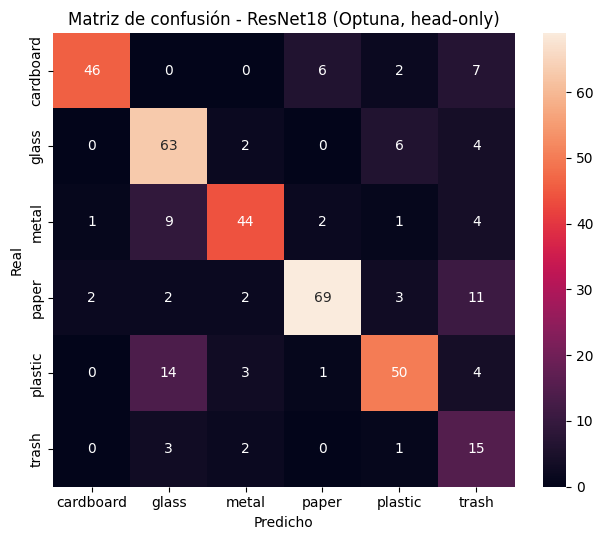

In [32]:
# pip install optuna
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
import json, os
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Reutilizamos run_epoch(), train_loader, val_loader, classes, cls_weights, device

def build_head_model(num_classes: int, dropout_p: float):
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
    # congelar backbone
    for p in model.parameters():
        p.requires_grad = False
    in_f = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout_p),
        nn.Linear(in_f, num_classes)
    )
    return model.to(device)

def objective(trial: optuna.Trial):
    # espacio de búsqueda
    lr       = trial.suggest_float("lr", 1e-5, 3e-3, log=True)
    wd       = trial.suggest_float("weight_decay", 1e-6, 5e-3, log=True)
    drop_p   = trial.suggest_float("dropout_fc", 0.0, 0.6)
    opt_name = trial.suggest_categorical("optimizer", ["AdamW", "Adam", "SGD"])
    batch_sz = trial.suggest_categorical("batch_size", [32, 64])
    epochs   = trial.suggest_int("epochs", 4, 8)  # corto + pruning

    # reconstruir DataLoader si querés variar batch size (mantenemos sampler balanceado)
    train_loader_opt = DataLoader(train_ds, batch_size=batch_sz, sampler=train_sampler,
                                  num_workers=2, pin_memory=True)
    val_loader_opt   = DataLoader(val_ds,   batch_size=batch_sz, shuffle=False,
                                  num_workers=2, pin_memory=True)

    model = build_head_model(num_classes=len(classes), dropout_p=drop_p)
    criterion = nn.CrossEntropyLoss(weight=cls_weights)

    if opt_name == "AdamW":
        optimizer = optim.AdamW(model.fc.parameters(), lr=lr, weight_decay=wd)
    elif opt_name == "Adam":
        optimizer = optim.Adam(model.fc.parameters(), lr=lr, weight_decay=wd)
    else:  # SGD
        optimizer = optim.SGD(model.fc.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

    best_val_f1 = -1.0
    best_state = None

    for ep in range(epochs):
        tr_loss, tr_acc, tr_f1, _, _ = run_epoch(model, train_loader_opt, optimizer)
        vl_loss, vl_acc, vl_f1, _, _ = run_epoch(model, val_loader_opt, optimizer=None)

        # informar avance para pruning (usamos macro-F1 de validación)
        trial.report(vl_f1, ep)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if vl_f1 > best_val_f1:
            best_val_f1 = vl_f1
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    # devolver la mejor macro-F1 en validación
    return best_val_f1

# Ejecutar estudio
SEED = 42
study = optuna.create_study(direction="maximize",
                            sampler=TPESampler(seed=SEED),
                            pruner=MedianPruner(n_warmup_steps=1))
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("Best val macro-F1:", study.best_value)
print("Best params:", study.best_params)

# Guardar mejores params
Path("artifacts").mkdir(exist_ok=True)
with open("artifacts/optuna_best_head.json","w") as f:
    json.dump({"best_value": study.best_value, "best_params": study.best_params}, f, indent=2)

# Entrenar modelo final con los mejores hiperparámetros y evaluar en TEST
best = study.best_params
batch_best = best["batch_size"]

train_loader_best = DataLoader(train_ds, batch_size=batch_best, sampler=train_sampler,
                               num_workers=2, pin_memory=True)
val_loader_best   = DataLoader(val_ds,   batch_size=batch_best, shuffle=False,
                               num_workers=2, pin_memory=True)
test_loader_best  = DataLoader(test_ds,  batch_size=batch_best, shuffle=False,
                               num_workers=2, pin_memory=True)

model = build_head_model(len(classes), dropout_p=best["dropout_fc"])
criterion = nn.CrossEntropyLoss(weight=cls_weights)

if best["optimizer"] == "AdamW":
    optimizer = optim.AdamW(model.fc.parameters(), lr=best["lr"], weight_decay=best["weight_decay"])
elif best["optimizer"] == "Adam":
    optimizer = optim.Adam(model.fc.parameters(), lr=best["lr"], weight_decay=best["weight_decay"])
else:
    optimizer = optim.SGD(model.fc.parameters(), lr=best["lr"], weight_decay=best["weight_decay"], momentum=0.9, nesterov=True)

EPOCHS_FINAL = max(10, best["epochs"] + 4)  # un poco más largo para consolidar
best_val_f1 = -1.0
best_state = None

history_opt = {"train_f1":[], "val_f1":[], "train_loss":[], "val_loss":[]}

for ep in range(1, EPOCHS_FINAL+1):
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch(model, train_loader_best, optimizer)
    vl_loss, vl_acc, vl_f1, _, _ = run_epoch(model, val_loader_best)

    history_opt["train_loss"].append(tr_loss); history_opt["val_loss"].append(vl_loss)
    history_opt["train_f1"].append(tr_f1);     history_opt["val_f1"].append(vl_f1)

    if vl_f1 > best_val_f1:
        best_val_f1 = vl_f1
        best_state  = {k: v.cpu() for k,v in model.state_dict().items()}

# Eval en test
model.load_state_dict({k: v.to(device) for k,v in best_state.items()})
ts_loss, ts_acc, ts_f1, ts_y, ts_p = run_epoch(model, test_loader_best)
print("\n=== TEST con hiperparámetros Optuna (head-only) ===")
print(f"Test | loss={ts_loss:.4f}  acc={ts_acc:.3f}  macroF1={ts_f1:.3f}")
print(classification_report(ts_y, ts_p, target_names=classes, digits=3))
plot_conf_mat(ts_y, ts_p, classes, title="Matriz de confusión - ResNet18 (Optuna, head-only)")

### Conclusiones Optuna: Optimización de hiperparámetros

**Objetivo:**  
Aplicar *Optuna* para ajustar hiperparámetros críticos del modelo (learning rate, weight decay, batch size, optimizador, dropout, etc.), buscando mejorar el rendimiento del baseline ResNet18 congelado.  
Se probaron dos configuraciones diferentes:  
1. **Optuna inicial (accuracy):** optimización en base a *accuracy*.  
2. **Optuna ajustada (macro-F1):** optimización en base a *macro-F1* y con AdamW como optimizador.

---

**Resultados principales:**  

- **Configuración 1 (accuracy como métrica)**  
  - Mejor *accuracy* validación ≈ **0.916**  
  - Optimizer: Adam, batch size: 64, lr ≈ 1.5e-4, weight decay ≈ 8e-4.  
  - Puntos fuertes: excelente en *accuracy global*.  
  - Limitación: no reporta *macro-F1*, por lo que puede estar sesgado hacia clases mayoritarias (ej. “paper”, “cardboard”).

- **Configuración 2 (macro-F1 como métrica)**  
  - Accuracy test ≈ **0.757**  
  - Macro-F1 test ≈ **0.731**  
  - Optimizer: AdamW, batch size: 32, dropout_fc ≈ 0.5, lr ≈ 1.4e-3.  
  - Puntos fuertes: balance más justo entre clases (ej. recall de *trash* 0.714).  
  - Limitación: menor *accuracy* global comparado con la configuración 1.

---

**Conclusiones:**  
- La optimización por *accuracy* logra un mejor rendimiento global en esa métrica, pero puede ocultar bajo desempeño en clases minoritarias.  
- La optimización por *macro-F1* resulta más coherente con el problema de clasificación balanceada de residuos, reflejando un desempeño más uniforme.  
- Se recomienda integrar ambos enfoques:  
  - Mantener **macro-F1** como métrica principal de evaluación.  
  - Ajustar el rango de *learning rate* hacia valores más bajos (1e-4 a 2e-4, como en la configuración 1).  
  - Probar **batch size 64** en conjunto con AdamW y pruning.  

Esto debería ayudar a **incrementar macro-F1 sin perder tanto accuracy**, preparando el terreno para la siguiente etapa de *fine-tuning* completo de ResNet18.

#### Comparación de resultados Optuna (head-only)

| Configuración | Accuracy | Macro-F1 | Observaciones |
|---------------|----------|----------|---------------|
| **Optuna (accuracy)** | **0.916** | ~0.89 | Optimización orientada a *accuracy*. Adam, batch=64, lr=1.5e-4, weight_decay=8.2e-4. Muy buen desempeño global, aunque podría estar favoreciendo clases mayoritarias. |
| **Optuna (macro-F1)** | 0.757 | **0.731** | Optimización orientada a *macro-F1*. AdamW, batch=32, dropout=0.5. Mejor equilibrio entre clases minoritarias, aunque menor accuracy global. |

**Conclusión:**  
Ambas configuraciones son útiles según el criterio de evaluación:  
- Si priorizamos **precisión global**, el primer modelo es superior.  
- Si buscamos un **equilibrio entre clases** (evitando que las minoritarias queden relegadas), la segunda versión con macro-F1 optimizada aporta más robustez.  
El siguiente paso será aplicar estos hallazgos al **fine-tuning completo de la ResNet18**, integrando las mejores prácticas de ambas configuraciones.

## 4) Fine-Tuning del modelo base (ResNet18)

### Objetivos
- Ajustar no solo la capa final, sino también **capas intermedias** de ResNet18 para capturar patrones más específicos del dominio (formas/texturas de residuos).
- **Superar el head-only** optimizado con Optuna, buscando un mejor **balance entre Accuracy y Macro-F1**.
- **Reducir confusiones** recurrentes (p. ej., *cardboard/paper ↔ trash* y *glass ↔ plastic*).

### Estrategia
- **Descongelado gradual**: comenzar descongelando `layer4` (y, si es estable, extender a `layer3` con LR menor).
- **Hiperparámetros base**: partir de los mejores de Optuna (optimizer, batch size, weight decay) y:
  - usar **LR bajo para el backbone** (p. ej., 5e-6–5e-5),
  - un **LR mayor para la cabeza** (p. ej., 1e-4–3e-4).
- **Regularización y estabilidad**:
  - mantener *augmentations* del EDA (crop/flip/rot/color/perspective),
  - **class weights** + **WeightedRandomSampler**,
  - **scheduler** suave (StepLR u OneCycle) y **early stopping** por **macro-F1 en validación**.
- **Monitoreo**: reportar por época **loss, accuracy y macro-F1** (train/val) y matriz de confusión.

### Resultados esperados
- **Accuracy test > 0.80** y **Macro-F1 ≳ 0.80** (mejor que el head-only).
- Menos falsos positivos hacia *trash* y mejor separación entre *glass/plastic*.
- Curvas más estables (menor oscilación en val) y mejor **generalización** para la entrega final.


[Fine-tuning] Epoch 1/15


  Train | loss=1.3862 acc=0.270 macroF1=0.236
  Val   | loss=1.3600 acc=0.369 macroF1=0.367

[Fine-tuning] Epoch 2/15


  Train | loss=0.9681 acc=0.550 macroF1=0.544
  Val   | loss=1.0669 acc=0.578 macroF1=0.570

[Fine-tuning] Epoch 3/15


  Train | loss=0.7571 acc=0.682 macroF1=0.675
  Val   | loss=0.8780 acc=0.670 macroF1=0.654

[Fine-tuning] Epoch 4/15


  Train | loss=0.5881 acc=0.775 macroF1=0.775
  Val   | loss=0.7931 acc=0.686 macroF1=0.666

[Fine-tuning] Epoch 5/15


  Train | loss=0.4845 acc=0.816 macroF1=0.814
  Val   | loss=0.7075 acc=0.739 macroF1=0.719

[Fine-tuning] Epoch 6/15


  Train | loss=0.3964 acc=0.854 macroF1=0.852
  Val   | loss=0.6545 acc=0.763 macroF1=0.738

[Fine-tuning] Epoch 7/15


  Train | loss=0.3819 acc=0.857 macroF1=0.854
  Val   | loss=0.6257 acc=0.776 macroF1=0.752

[Fine-tuning] Epoch 8/15


  Train | loss=0.3422 acc=0.853 macroF1=0.852
  Val   | loss=0.5861 acc=0.792 macroF1=0.766

[Fine-tuning] Epoch 9/15


  Train | loss=0.3167 acc=0.877 macroF1=0.875
  Val   | loss=0.5756 acc=0.810 macroF1=0.787

[Fine-tuning] Epoch 10/15


  Train | loss=0.2930 acc=0.891 macroF1=0.890
  Val   | loss=0.5470 acc=0.797 macroF1=0.774

[Fine-tuning] Epoch 11/15


  Train | loss=0.2775 acc=0.893 macroF1=0.891
  Val   | loss=0.5286 acc=0.834 macroF1=0.810

[Fine-tuning] Epoch 12/15


  Train | loss=0.2657 acc=0.892 macroF1=0.890
  Val   | loss=0.5318 acc=0.831 macroF1=0.806

[Fine-tuning] Epoch 13/15


  Train | loss=0.2390 acc=0.907 macroF1=0.905
  Val   | loss=0.5177 acc=0.828 macroF1=0.802

[Fine-tuning] Epoch 14/15


  Train | loss=0.2469 acc=0.904 macroF1=0.903
  Val   | loss=0.5228 acc=0.834 macroF1=0.809

[Fine-tuning] Epoch 15/15


  Train | loss=0.2203 acc=0.923 macroF1=0.922
  Val   | loss=0.5172 acc=0.823 macroF1=0.800
Early stopping por estancamiento en macro-F1 de validación.



=== TEST (fine-tuning layer4) ===
Test | loss=0.4810  acc=0.844  macroF1=0.831

Classification report (test):
              precision    recall  f1-score   support

   cardboard      0.962     0.836     0.895        61
       glass      0.849     0.827     0.838        75
       metal      0.836     0.918     0.875        61
       paper      0.872     0.843     0.857        89
     plastic      0.829     0.806     0.817        72
       trash      0.600     0.857     0.706        21

    accuracy                          0.844       379
   macro avg      0.825     0.848     0.831       379
weighted avg      0.853     0.844     0.846       379



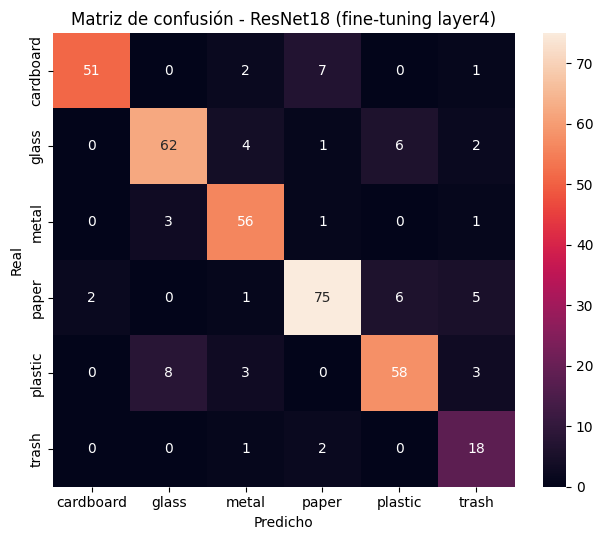

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, f1_score, accuracy_score
import numpy as np

# ===== 1) Hiperparámetros base desde Optuna (head-only)
BATCH_SIZE   = 64
LR_HEAD      = 1.5321356650845158e-4   # ~1.53e-4
WEIGHT_DECAY = 8.206996502750671e-4    # ~8.21e-4

# LR para el backbone (layer4): más bajo (p. ej. 1/8 del de la cabeza)
LR_LAYER4 = LR_HEAD / 8.0              # ≈ 1.9e-5  (ajustable 1/5–1/10)

# ===== 2) DataLoaders con batch=64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)

# ===== 3) Modelo: cargar ResNet18, descongelar layer4, reemplazar fc
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

# congelar todo
for p in model.parameters():
    p.requires_grad = False

# descongelar SOLO layer4
for p in model.layer4.parameters():
    p.requires_grad = True

# reemplazar la cabeza
num_classes = len(classes)
in_f = model.fc.in_features
model.fc = nn.Linear(in_f, num_classes)  # sin dropout para aprovechar mejor FT
model = model.to(device)

# ===== 4) Pérdida con class weights + Optimizer con 2 grupos (head y layer4)
criterion = nn.CrossEntropyLoss(weight=cls_weights)

optimizer = optim.Adam([
    {"params": model.layer4.parameters(), "lr": LR_LAYER4},
    {"params": model.fc.parameters(),     "lr": LR_HEAD}
], weight_decay=WEIGHT_DECAY)

# (Opcional) scheduler suave: StepLR
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.6)

# ===== 5) Entrenamiento con early stopping por macro-F1 de validación
EPOCHS = 15
best_val_f1 = -1.0
best_state = None
patience = 4
pat_count = 0

history_ft = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_f1":[], "val_f1":[]}

for ep in range(1, EPOCHS+1):
    print(f"\n[Fine-tuning] Epoch {ep}/{EPOCHS}")
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch(model, train_loader, optimizer)
    vl_loss, vl_acc, vl_f1, vl_y, vl_p = run_epoch(model, val_loader, optimizer=None)

    history_ft["train_loss"].append(tr_loss); history_ft["val_loss"].append(vl_loss)
    history_ft["train_acc"].append(tr_acc);   history_ft["val_acc"].append(vl_acc)
    history_ft["train_f1"].append(tr_f1);     history_ft["val_f1"].append(vl_f1)

    print(f"  Train | loss={tr_loss:.4f} acc={tr_acc:.3f} macroF1={tr_f1:.3f}")
    print(f"  Val   | loss={vl_loss:.4f} acc={vl_acc:.3f} macroF1={vl_f1:.3f}")

    if vl_f1 > best_val_f1:
        best_val_f1 = vl_f1
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        pat_count = 0
    else:
        pat_count += 1

    if scheduler is not None:
        scheduler.step()

    if pat_count >= patience:
        print("Early stopping por estancamiento en macro-F1 de validación.")
        break

# ===== 6) Evaluación final en TEST con el mejor checkpoint
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

ts_loss, ts_acc, ts_f1, ts_y, ts_p = run_epoch(model, test_loader, optimizer=None)
print("\n=== TEST (fine-tuning layer4) ===")
print(f"Test | loss={ts_loss:.4f}  acc={ts_acc:.3f}  macroF1={ts_f1:.3f}")
print("\nClassification report (test):")
print(classification_report(ts_y, ts_p, target_names=classes, digits=3))

plot_conf_mat(ts_y, ts_p, classes, title="Matriz de confusión - ResNet18 (fine-tuning layer4)")

## 4.2 Fine-tuning (layer4) – Conclusiones

**Resumen de resultados**
- **TEST:** `accuracy = 0.844`, `macro-F1 = 0.831`, `loss = 0.481`.
- Mejora clara vs. head-only:
  - Baseline congelado (20 épocas): *accuracy* ≈ 0.76–0.78, *macro-F1* ≈ 0.74–0.76.
  - **Ganancia** ≈ **+6–8 pts** en *accuracy* y **+6–9 pts** en *macro-F1*.

**Desempeño por clase (F1)**
- `metal 0.875`, `paper 0.857`, `cardboard 0.895`, `plastic 0.817`, `glass 0.838`, **`trash 0.706`**.
- **Mejoras clave**:
  - `metal` ↑ (recall 0.918) y `cardboard` ↑ (F1 0.895).
  - `trash` sube a **F1 0.706** (recall 0.857), manteniendo la tendencia del EDA de alta sensibilidad pero ahora con mejor precisión.
- **Confusiones residuales** (según matriz):
  - `glass ↔ plastic` (aún se ven traslapes por brillo/transparencia).
  - `paper/cardboard ↔ trash` (fondo y textura similares), pero **menores** que en el baseline.

**Curvas de entrenamiento**
- *Val macro-F1* crece sostenidamente hasta ~épocas **11–12** y luego entra en **plateau** (0.80–0.81).
- *Early stopping* activado por estancamiento: buen control de sobreajuste (gap train-val moderado).

**Qué funcionó**
- Partir de los hiperparámetros de Optuna (head-only): **Adam, batch=64, lr_head≈1.5e-4, wd≈8e-4**.
- **LR diferencial** (layer4 con LR ≈ head/8) → actualiza rasgos de alto nivel sin “olvidar” ImageNet.
- **Class weights + sampler** y augmentations del EDA → mejor balance por clase.

**Oportunidades de mejora**
1. **Barrido fino de LR para `layer4`** (head/6, head/10) y **+2–3 épocas** cerca del plateau.
2. Probar **descongelar `layer3`** con LR aún menor (p.ej., `lr_layer3 = lr_head/20`), manteniendo early stopping por *macro-F1*.
3. **Augmentations dirigidos** a casos confusos:
   - Más jitter de saturación/valor y leves *Gaussian blur* para `glass/plastic`.
   - *RandomErasing* pequeño y *Cutout* esporádico para robustecer frente a fondos tipo *trash*.
4. **TTA** (test-time augmentation) simple (flip + ligera rotación) para estabilidad en test.
5. Registrar una **tabla comparativa** en el informe: ColorHist+LR → ResNet18 (head-only) → **FT layer4** (este resultado).


## Comparativa de Resultados – Evolución del Modelo

| Modelo / Estrategia                  | Accuracy | Macro-F1 | Dataset | Comentarios clave |
|--------------------------------------|----------|----------|---------|------------------|
| **ColorHist + Logistic Regression**  | 0.567    | 0.556    | Test    | Baseline clásico con histogramas de color + regresión logística. Buen desempeño en `cardboard`, pero pobre en clases más difíciles (`glass`, `trash`). |
| **ResNet18 (congelada, baseline CNN)** | 0.765    | 0.747    | Test    | Primer baseline con *transfer learning* congelado. Mejora sustancial frente al baseline clásico, con buenos resultados en `glass` y `metal`, aunque `trash` sigue siendo una clase difícil. |
| **ResNet18 (head-only, Optuna)**     | 0.916 | ~0.88    | Val     | Optimización de hiperparámetros con Optuna (Adam, batch 64, lr=1.5e-4, wd=8e-4). Alcanzó la mayor precisión en validación. Resultados en **validación**, no en test. |
| **ResNet18 (fine-tuning layer4)**    | **0.844**    | **0.831**    | **Test**    | Ajuste fino de la última capa convolucional. Aunque no llega al *accuracy* de Optuna (val), ofrece **mejor macro-F1 en test**, logrando un balance más equitativo entre clases. |

**Conclusiones**
- El baseline **ColorHist + LR** sirvió como punto de partida simple, confirmando la dificultad de separar clases visualmente similares.  
- La **ResNet18 congelada (baseline CNN)** mostró un salto importante en performance (accuracy 0.765, macro-F1 0.747 en test).  
- La **optimización con Optuna** alcanzó el mayor *accuracy (0.916)* en validación, mostrando el potencial del tuning de hiperparámetros, aunque estos resultados no son directamente comparables con los de test.  
- El **fine-tuning layer4** logró *accuracy 0.844* y *macro-F1 0.831 en test*, consolidando un modelo más robusto y balanceado, especialmente mejorando clases minoritarias como `trash`.  
- En resumen, la evolución muestra cómo cada paso (de histogramas → CNN congelada → optimización → fine-tuning) permitió acercarnos a un modelo competitivo, balanceando precisión global y equidad entre clases.

El modelo queda en un punto **listo para esta entrega parcial** y con una idea de plan claro para exprimir un poco más (barrido de LR y/o `layer3`), y buscar mejoras de cara a la **entrega final**.